In [1]:
from collections import defaultdict
import json
import os
import sys
import time

# from scipy.stats import mannwhitneyu
import numpy as np
# import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
# from ete3 import PhyloTree
from rna_tools.SecondaryStructure import parse_vienna_to_pairs
import seaborn as sns

sys.path.append('../src/')
# from mutations_extractor import get_sequence, node_parent, read_fasta_generator
from utils import get_sequence, node_parent, read_fasta_generator, read_ss_file

In [2]:
# https://stackoverflow.com/questions/46768859/how-to-change-the-default-colors-for-multiple-plots-in-matplotlib

import matplotlib.pyplot as plt
# to change default colormap
plt.rcParams["image.cmap"] = "Greys"
# to change default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

In [3]:
REFSEQ_PATH = "../data/covid_ref.fasta"
SUBSTITUTIONS_PATH = "../data/overall_mutations_2.json"
# SEC_STRUCT_PATH_v1 = "../data/structure_data/SARSCoV2-RNA.ss"
# SEC_STRUCT_PATH_from_site = "../data/structure_data/SARSCoV2-RNA_from_site_0based.ss"
SEC_STRUCT_PATH = "../data/structure_data/SARSCoV2-RNA_from_site_plus_0based_with_URTs.ss"
MUTSPEC_TABLE_PATH = '../data/ideal_table_of_sasha.csv'

In [4]:
refseq = next(read_fasta_generator(REFSEQ_PATH))[1].replace('\n', '')
len(refseq)

29903

In [5]:
ss_clusters = read_ss_file(SEC_STRUCT_PATH)
# ss_clusters = read_ss_file(SEC_STRUCT_PATH_v1)
print(ss_clusters[0])

('>motif_0-299', 0, 299, [(6, 32), (7, 31), (8, 30), (9, 29), (10, 28), (12, 25), (13, 24), (14, 23), (15, 22), (16, 21), (44, 58), (45, 57), (46, 56), (47, 55), (48, 54), (60, 74), (61, 73), (62, 72), (63, 71), (83, 126), (84, 125), (85, 124), (86, 123), (87, 122), (88, 121), (89, 120), (90, 119), (92, 117), (93, 116), (95, 115), (96, 114), (97, 113), (98, 112), (100, 110), (101, 109), (102, 108), (129, 145), (130, 144), (131, 143), (132, 142), (133, 141), (134, 140), (149, 293), (150, 292), (151, 291), (152, 290), (153, 289), (154, 288), (155, 287), (156, 283), (157, 282), (158, 281), (159, 280), (162, 278), (163, 277), (164, 276), (165, 275), (166, 274), (170, 272), (171, 271), (172, 270), (174, 269), (175, 268), (176, 267), (177, 266), (178, 265), (179, 264), (180, 263), (181, 262), (182, 226), (183, 225), (184, 224), (187, 217), (188, 216), (189, 215), (190, 214), (191, 213), (192, 212), (194, 209), (195, 208), (196, 207), (197, 206), (198, 205), (227, 251), (228, 250), (229, 249)

In [6]:
# df = ideal_table.groupby("Pos")[["RefNuc", "GenName"]].max().reset_index()
df = pd.read_csv('../data/genes_annotation.csv')

# Типы вторички считаются неверно!!!
Поэтому проверяем is_stem

In [7]:
genome_is_stem = defaultdict(int)
genome_ss_pairs = defaultdict(lambda: None)

for j in range(len(ss_clusters)):
    cur_ss = ss_clusters[j]
    start, stop = cur_ss[1:3]
    types = cur_ss[5]
    pairs_dct = cur_ss[4]

    for i in range(start, stop + 1):
        ss_idx = i - start
        genome_is_stem[i] = 0
        if types[ss_idx] == 1:
            genome_is_stem[i] = 1
            genome_ss_pairs[i] = pairs_dct[ss_idx] + start

In [8]:
df['IsStem'] = pd.Series(genome_is_stem)
df['SsPairs'] = pd.Series(genome_ss_pairs)

In [9]:
i = 600
df[i: i + 5]

,Pos,RefNuc,GenName,IsStem,SsPairs
600,601,C,ORF1ab,1.0,586.0
601,602,G,ORF1ab,1.0,585.0
602,603,A,ORF1ab,1.0,584.0
603,604,A,ORF1ab,0.0,NaN
604,605,A,ORF1ab,1.0,581.0


In [10]:
# check if ss_pairs is not nan only where ss_type == 1
assert ~np.any(df[df.IsStem == 1].SsPairs.isna())
assert np.any(df[df.IsStem != 1].SsPairs.isna())

In [11]:
# df.to_csv("../data/secondary_structure_on_genome.csv", index=None)

In [12]:
gr = df.groupby("IsStem")

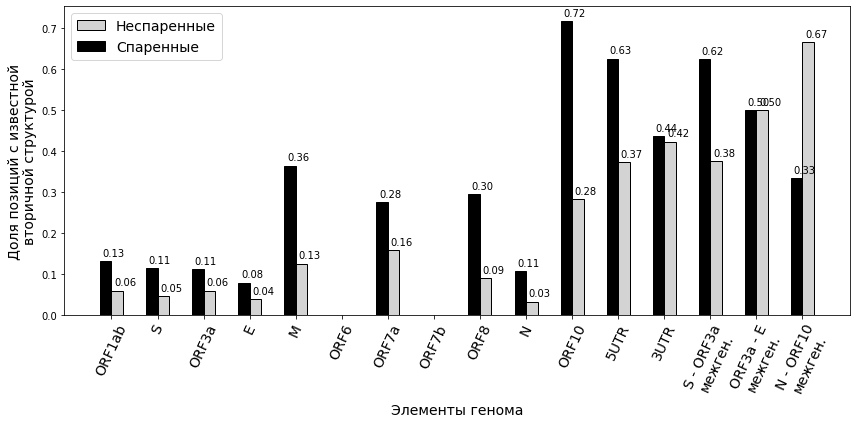

In [13]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

# labels = (gr.get_group(0).GenName.value_counts() /
#           df.GenName.value_counts()).index
labels = [
    'ORF1ab', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b',
    'ORF8', 'N', 'ORF10', '5UTR', '3UTR', 
#     'ORF1ab-S_space', 
    'S-ORF3a_space','ORF3a-E_space', 
#     'E-M_space', 'M-ORF6_space', 'ORF6-ORF7a_space',
#     'ORF7a-ORF7b_overlay', 'ORF7b-ORF8_space', 'ORF8-N_space', 
    'N-ORF10_space',
]
ss_structures = [
    "Неспаренные",
    "Спаренные", 
]
colors = [
    'lightgray',
    'black',
]


# на что нормировать? На полную длину гена/негена или только на ту длину, для которой есть вторичка???
values = [(gr.get_group(i).GenName.value_counts() /
           df.GenName.value_counts())[labels].values for i in range(gr.ngroups)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

collection_of_rects = []
for i, v in enumerate(values):
    rects = ax.bar(x + (-1)**i * width / 2 , v, width, 
                   label=ss_structures[i], color=colors[i], edgecolor='k')
#     rects1 = ax.bar(x - width/2, men_means, width, label='Men')
    collection_of_rects.append(rects)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Доля позиций с известной\nвторичной структурой', fontsize=14)
ax.set_xlabel("Элементы генома", fontsize=14)
# ax.set_title('Amount of nucleotides in stem or not across all genome structures')
ax.set_xticks(x)

nice_labels = [
    x.replace('-', ' - ').replace('_space', '\nмежген.') if 'space' in x else x for x in labels
]

ax.set_xticklabels(nice_labels, rotation=65, fontsize=14)
ax.legend(fontsize=14)  # loc='upper right'


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(8, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

for r in collection_of_rects:
    autolabel(r)

fig.tight_layout()

plt.show()

In [14]:
annot = pd.read_csv('../data/gemone_structures_annot.csv')
annot.head(2)

,Pos,RefNuc,GenName,IsStem,SsPairs,NSubst,IsTRS
0,1,A,5UTR,NaN,NaN,89,0
1,2,T,5UTR,NaN,NaN,122,0


Add known stems

In [15]:
annot['IsStem'] = df.IsStem
annot['SsPairs'] = df.SsPairs
annot['IsRS'] = 0

# RS of 3'UTR
annot.loc[29533+73:29533+79, 'IsRS'] = 1  # stem
annot.loc[29533+105:29533+113, 'IsRS'] = 1  # loop

# RS of 5'UTR
annot.loc[28:28+4, 'IsRS'] = 1  # stem
annot.loc[49:49+4, 'IsRS'] = 1  # tetraloop

# annot.to_csv('../data/gemone_structures_annot_with_UTRs.csv', index=None)

In [18]:
annot[(annot.IsRS == 1) & (annot.IsStem == 1)]

,Pos,RefNuc,GenName,IsStem,SsPairs,NSubst,IsTRS,IsRS
28,29,A,5UTR,1.0,10.0,121,0,1
29,30,A,5UTR,1.0,9.0,226,0,1
30,31,A,5UTR,1.0,8.0,247,0,1
31,32,C,5UTR,1.0,7.0,59,0,1
32,33,C,5UTR,1.0,6.0,63,0,1
29606,29607,T,ORF10,1.0,29553.0,27,0,1
29607,29608,C,ORF10,1.0,29552.0,0,0,1
29608,29609,T,ORF10,1.0,29551.0,8,0,1
29609,29610,T,ORF10,1.0,29550.0,0,0,1
29610,29611,G,ORF10,1.0,29549.0,0,0,1


### Данные позиции будем использовать для подсчета мутспека на железобетонных вторичках

In [ ]:
p1 = annot[(annot.IsRS == 1) & (annot.IsStem == 1)].Pos.values  # 1-based
p2 = annot[(annot.IsTRS == 1) & (annot.IsStem == 1)].Pos.values  # 1-based

In [40]:
pos_for_mutspec = sorted(list(p1) + list(p2))
print(pos_for_mutspec)

assert len(pos_for_mutspec) == len(set(pos_for_mutspec))

[29, 30, 31, 32, 33, 64, 72, 73, 74, 75, 25380, 25381, 25382, 25383, 25384, 25385, 25386, 25387, 25388, 25389, 26231, 26232, 26233, 26234, 26235, 26236, 26237, 26238, 27035, 27036, 27037, 27038, 27039, 27042, 27043, 27044, 27045, 27047, 27048, 29607, 29608, 29609, 29610, 29611, 29612, 29613, 29639, 29640, 29645, 29646]


In [46]:
gis = pd.read_csv('../data/gisaid_mutations_annotation.csv')
gis['Pos'] = gis.pos + 1
len(gis)

631299

In [63]:
gis_for_trs_rs = gis[
    (~ gis.child_node.str.startswith('#')) &
    (gis.parent_nucl != '-') &
    (gis.child_nucl != '-') &
    ((gis.child_aa == gis.parent_aa) | (gis.child_aa.isna())) &
    (gis.Pos.isin(pos_for_mutspec))
]

In [64]:
print(gis_for_trs_rs.shape)
gis_for_trs_rs.head()

(263, 13)


,pos,parent_nucl,child_nucl,parent_node,child_node,GenName,GenType,CodonNumber,child_codon,parent_codon,child_aa,parent_aa,Pos
45663,27046,T,G,#27714#,hCoV-19/USA/CA-ALSR-3186/2020|EPI_ISL_635904|2...,M,translated,8899.0,ACG,ACT,T,T,27047
45667,27046,G,T,#37608#,hCoV-19/USA/IL-USAFSAM-S340/2020|EPI_ISL_81264...,M,translated,8899.0,ACT,ACG,T,T,27047
45670,27046,T,G,#17760#,hCoV-19/USA/TX-HMH-MCoV-10159/2020|EPI_ISL_789...,M,translated,8899.0,ACG,ACT,T,T,27047
45673,27046,T,G,#43066#,hCoV-19/USA/MN-MDH-1728/2020|EPI_ISL_576237|20...,M,translated,8899.0,ACG,ACT,T,T,27047
45675,27046,G,T,#28030#,hCoV-19/USA/CA-LACPHL-AE00045/2020|EPI_ISL_735...,M,translated,8899.0,ACT,ACG,T,T,27047


In [62]:
gis_for_trs_rs.to_csv('../data/gisaid_only_for_TRS-RS.csv', index=None)

In [2]:
fulltree = pd.read_csv("../data/fulltree.csv", delimiter=';')
hgt_fulltreeCodons = pd.read_csv("../data/human-global-tree_fulltreeCodons_from.csv", delimiter=';')

In [3]:
fulltree.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2


In [48]:
hgt_fulltreeCodons.head(3)

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,synonymous,ancestral_aa,derived_aa,note
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,non-synonymous,Asn,Asp,normal


In [49]:
hgt_fulltreeCodons.columns

Index(['first', 'second', 'position', 'ref_pos', 'ancestor', 'descendant',
       'nuc_ref_in_ali', 'gene_info', 'gene_start', 'pos_in_codon',
       'synonymous', 'ancestral_aa', 'derived_aa', 'note'],
      dtype='object')